# Implementation of a comparison of Split and uncalibrated scenarion

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import multiprocessing as mp
from src.util import sigmoid
from src.feature_map import IdentityFeatureMap
from src.functions import cost_utility, demographic_parity
from src.plotting import plot_mean_over_time, plot_median_over_time, plot_mean_over_lambdas, plot_median_over_lambdas
from src.training import train
from src.distribution import SplitDistribution, UncalibratedScore

In [2]:
def fairness_function(**fairness_kwargs):
    policy = fairness_kwargs["policy"]
    x = fairness_kwargs["x"]
    s = fairness_kwargs["s"]
    y = fairness_kwargs["y"]
    decisions = fairness_kwargs["decisions"]
    ips_weights = fairness_kwargs["ips_weights"]
    numerator, denominator_log_grad = policy._log_gradient(x, s)

    benefit = policy.benefit_function(decisions=decisions, y=y)
    benefit_gradient = benefit / denominator_log_grad

    if ips_weights is not None:
        benefit *= ips_weights
        benefit_gradient *= ips_weights

    benefit_grad = numerator * benefit_gradient
        
    # benefit-difference * grad-benefit-difference
    return policy._mean_difference(benefit, s) * policy._mean_difference(benefit_grad, s)

## Uncalibrated Score

In [3]:
bias = True
dim_x = 1
dim_theta = dim_x + 1 if bias else dim_x

def util_func(**util_params):
    util = cost_utility(cost_factor=0.142, **util_params)
    return util

training_parameters = {    
    'model':{
        'theta': [-3.0, 5.0],
        'benefit_function': demographic_parity,
        'utility_function': util_func,
        'fairness_function': fairness_function,
        'feature_map': IdentityFeatureMap(dim_theta),
        'keep_collected_data': False,
        'use_sensitve_attributes': False,
        'bias': bias
    },
    'optimization': {
        'time_steps':200,
        'epochs': 1,
        'batch_size':256,
        'learning_rate': 1,
        'decay_rate': 1,
        'decay_step': 10000
    },
    'data': {
        'distribution': UncalibratedScore(bias=bias),
        'keep_data_across_lambdas': True,
        'fraction_protected':0.5,
        'num_test_samples': 8192,
        'num_decisions': 128 * 256
    }
}


--------------------------------------------------
------------------- Lambda 0.0 -------------------
--------------------------------------------------


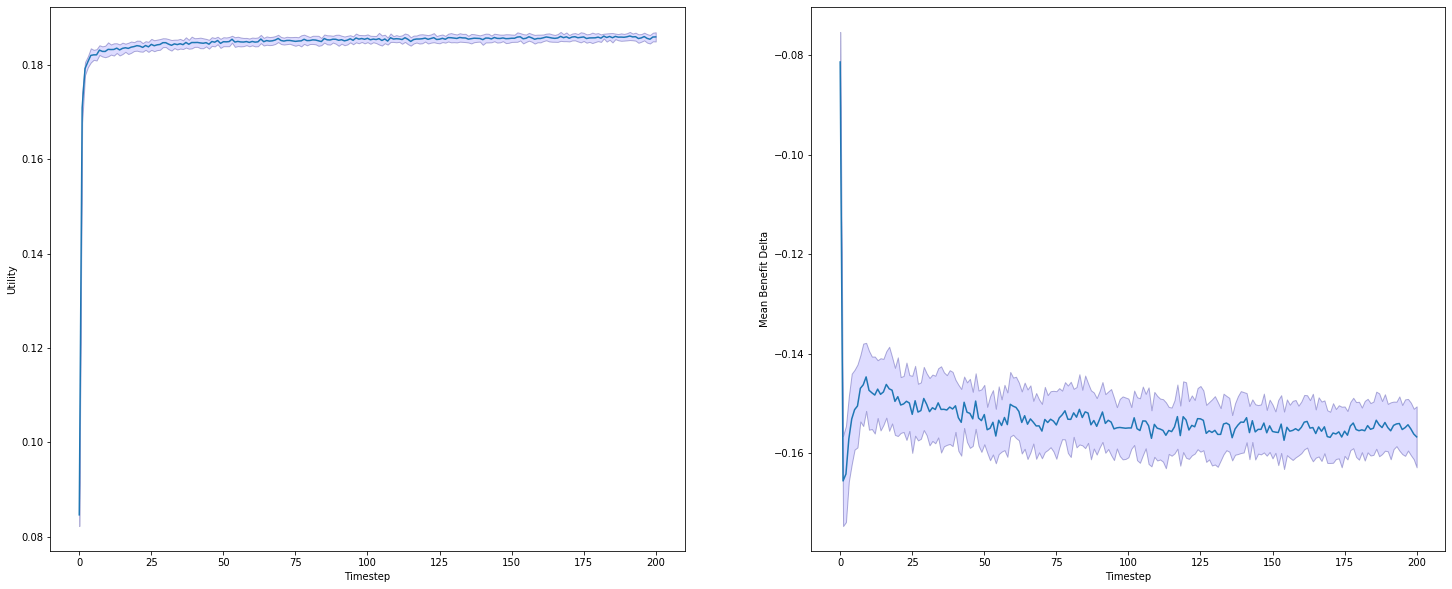

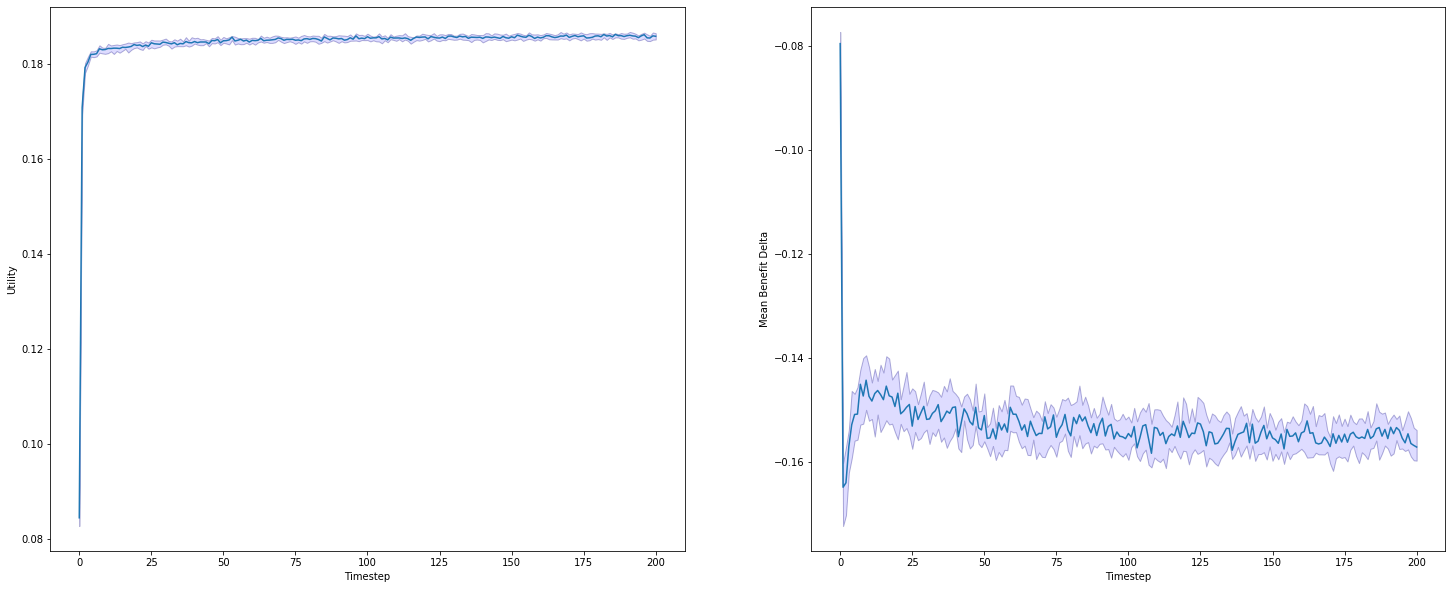

In [4]:
training_parameters["save_path"] = "/home/fkretschmar/Documents/master-thesis/res/exp-007/uncalibrated/time"
statistics, run_path = train(training_parameters, fairness_rates=[0.0], iterations=30, verbose=False, asynchronous=True)

plot_mean_over_time(statistics, "{}/results_mean_time.png".format(run_path))
plot_median_over_time(statistics, "{}/results_median_time.png".format(run_path))

--------------------------------------------------
------------------- Lambda 0.0 -------------------
--------------------------------------------------
------------------- Utility ----------------------
Mean: 0.176089599609375
Standard deviation: 0.0008427002605024851
First quartile: 0.1754324951171875
Median: 0.1762052001953125
Last quartile: 0.17648809814453126
------------------- Benefit Delta ----------------
Mean: -0.15056806517059915
Standard deviation: 0.006214206927834567
First quartile: -0.1548984791467176
Median: -0.14988470888434507
Last quartile: -0.14693315499494997
--------------------------------------------------
------------------- Lambda 0.1 -------------------
--------------------------------------------------
------------------- Utility ----------------------
Mean: 0.1701183268229167
Standard deviation: 0.03160233243228841
First quartile: 0.175333740234375
Median: 0.1760086669921875
Last quartile: 0.17644470214843752
------------------- Benefit Delta --------------

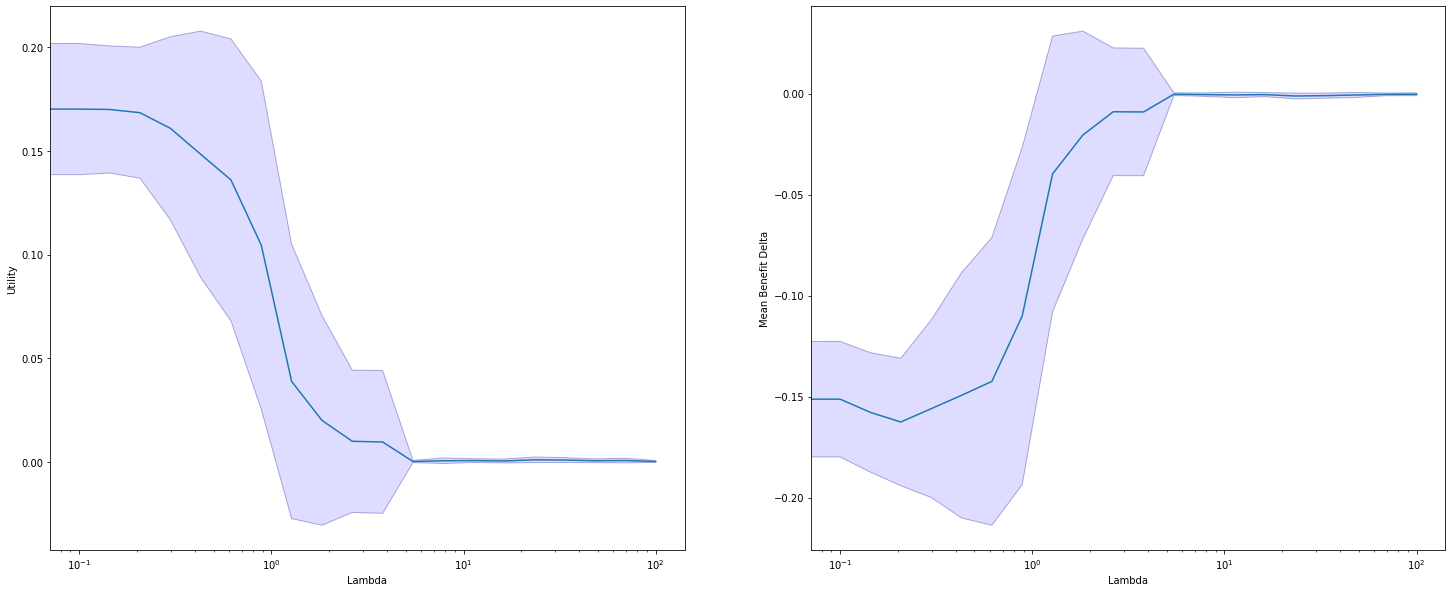

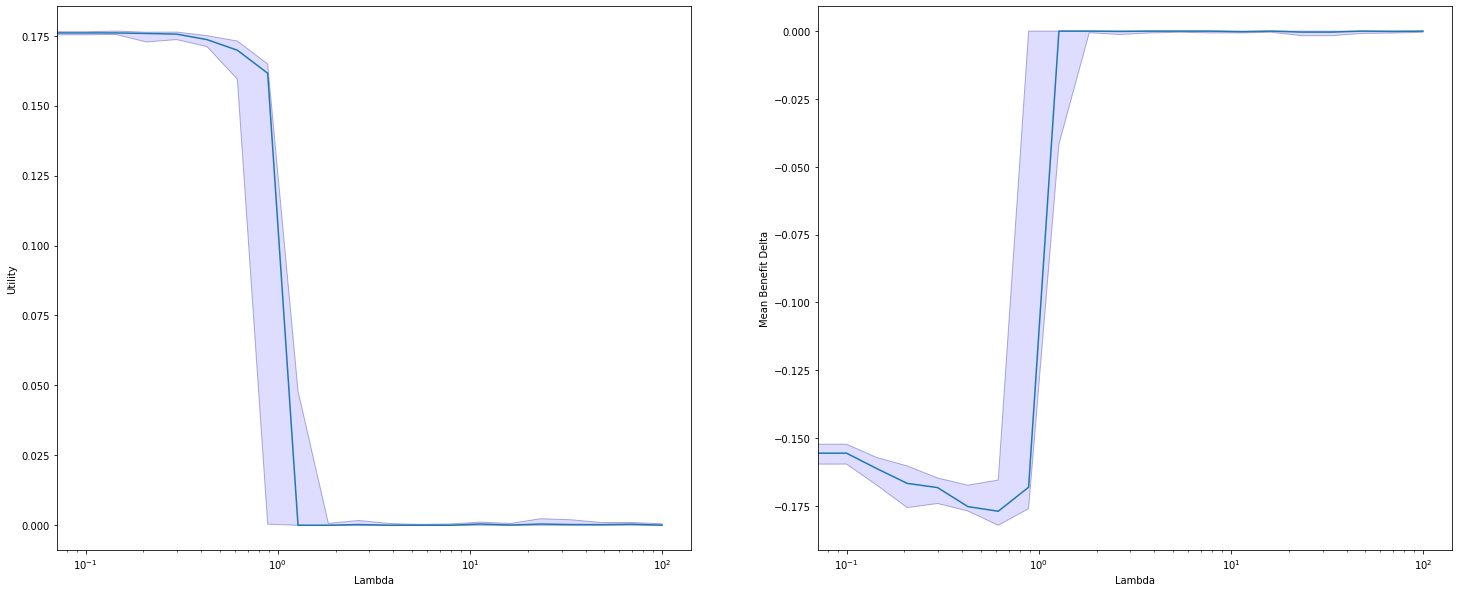

In [5]:
training_parameters["save_path"] = "/home/fkretschmar/Documents/master-thesis/res/exp-007/uncalibrated/lambda"
lambdas = np.logspace(-1, 2, base=10, endpoint=True, num=20)
lambdas = np.insert(arr=lambdas, obj=0, values=[0.0])

statistics, run_path = train(training_parameters, fairness_rates=lambdas, iterations=30, verbose=True, asynchronous=True)

plot_mean_over_lambdas(statistics, "{}/results_mean_lambdas.png".format(run_path))
plot_median_over_lambdas(statistics, "{}/results_median_lambdas.png".format(run_path))

## Split Distribution

In [6]:
bias = True
dim_x = 1
dim_theta = dim_x + 1 if bias else dim_x

def util_func(**util_params):
    util = cost_utility(cost_factor=0.55, **util_params)
    return util

training_parameters = {    
    'model':{
        'theta': [-3.5, 0.6],
        'benefit_value_function': demographic_parity,
        'utility_value_function': util_func,
        'fairness_function': fairness_function,
        'feature_map': IdentityFeatureMap(dim_theta),
        'keep_collected_data': False,
        'use_sensitve_attributes': False,
        'bias': bias
    },
    'optimization': {
        'time_steps':200,
        'epochs': 32,
        'batch_size':512,
        'learning_rate': 0.5,
        'decay_rate': 0.8,
        'decay_step': 30,
        'test_at_every_timestep': False
    },
    'data': {
        'distribution': SplitDistribution(bias=bias),
        'keep_data_across_lambdas': True,
        'fraction_protected':0.5,
        'num_test_samples': 20480,
        'num_decisions': 32 * 512
    }
}

70117e-04 -4.94384766e-05
 -7.69042969e-05 -4.94384766e-05 -9.46044922e-05 -7.38525391e-05
 -7.01904297e-05 -4.39453125e-05 -5.37109375e-05 -5.55419922e-05
 -5.31005859e-05 -5.37109375e-05 -1.02539063e-04 -5.37109375e-05
 -1.11083984e-04 -6.83593750e-05 -8.23974609e-05 -4.82177734e-05
 -1.09863281e-04 -8.11767578e-05 -4.51660156e-05 -7.56835938e-05
 -5.18798828e-05 -8.05664063e-05 -1.33056641e-04 -9.52148438e-05
 -9.21630859e-05 -4.88281250e-05 -1.14135742e-04 -8.42285156e-05
 -8.05664063e-05 -7.62939453e-05 -5.37109375e-05 -4.02832031e-05
 -5.55419922e-05 -9.33837891e-05 -6.95800781e-05 -7.75146484e-05
 -7.75146484e-05 -9.39941406e-05 -6.28662109e-05 -6.65283203e-05
 -4.94384766e-05]
Median: [ 1.24096680e-02  1.28771973e-02  1.50073242e-02  1.43200684e-02
  1.56250000e-04  3.41796875e-05  3.66210937e-06  1.46484375e-05
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.70898437e-05  8.54492187e-06
  0.00000000e+00  0.00000000e+00  0.00

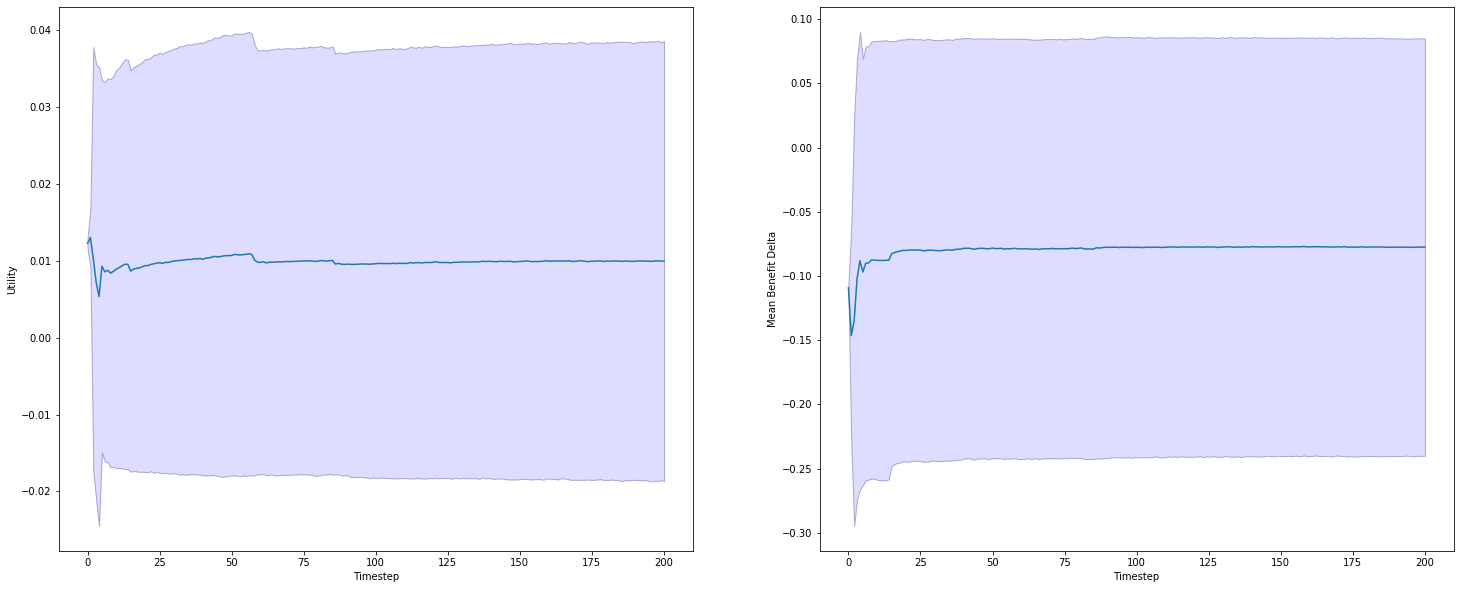

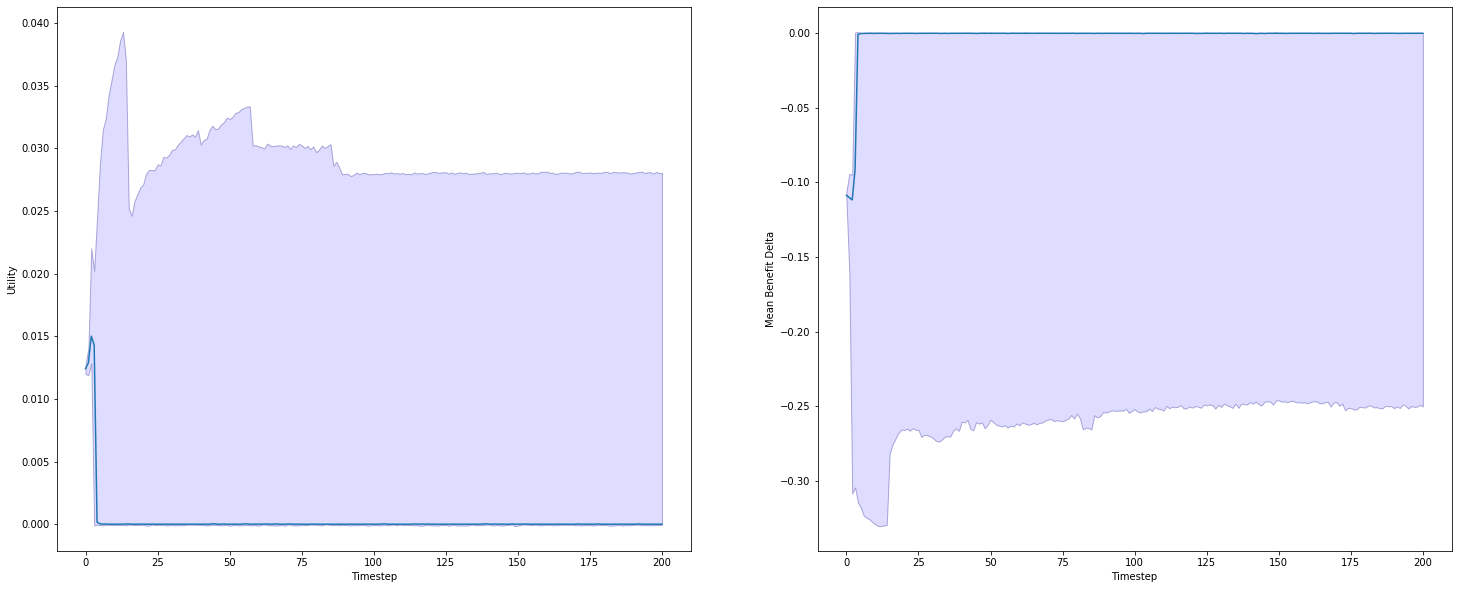

In [7]:
training_parameters["save_path"] = "/home/fkretschmar/Documents/master-thesis/res/exp-007/split/time"
statistics, run_path = train(training_parameters, fairness_rates=[1.0], iterations=30, verbose=True, asynchronous=True)

plot_mean_over_time(statistics, "{}/results_mean.png".format(run_path))
plot_median_over_time(statistics, "{}/results_median.png".format(run_path))

--------------------------------------------------
------------------- Lambda 0.0 -------------------
--------------------------------------------------
------------------- Utility ----------------------
Mean: 0.05332470703124997
Standard deviation: 0.020746653796406916
First quartile: 0.059695434570312476
Median: 0.06003784179687498
Last quartile: 0.06043334960937498
------------------- Benefit Delta ----------------
Mean: -0.25208159582579853
Standard deviation: 0.1402677088821506
First quartile: -0.2987675195102947
Median: -0.2965316603421146
Last quartile: -0.292971316462009
--------------------------------------------------
------------------- Lambda 0.1 -------------------
--------------------------------------------------
------------------- Utility ----------------------
Mean: 0.04531233723958332
Standard deviation: 0.02597041206636335
First quartile: 0.052254638671874985
Median: 0.06007080078124999
Last quartile: 0.060499267578124995
------------------- Benefit Delta ---------

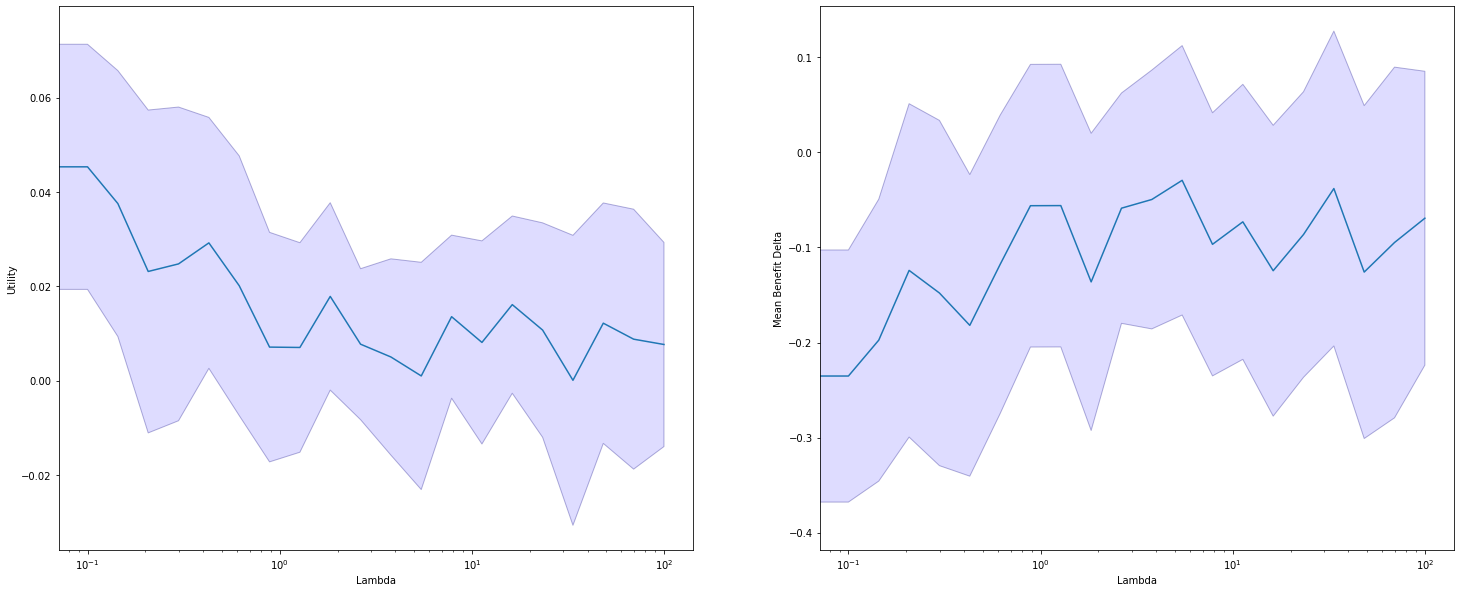

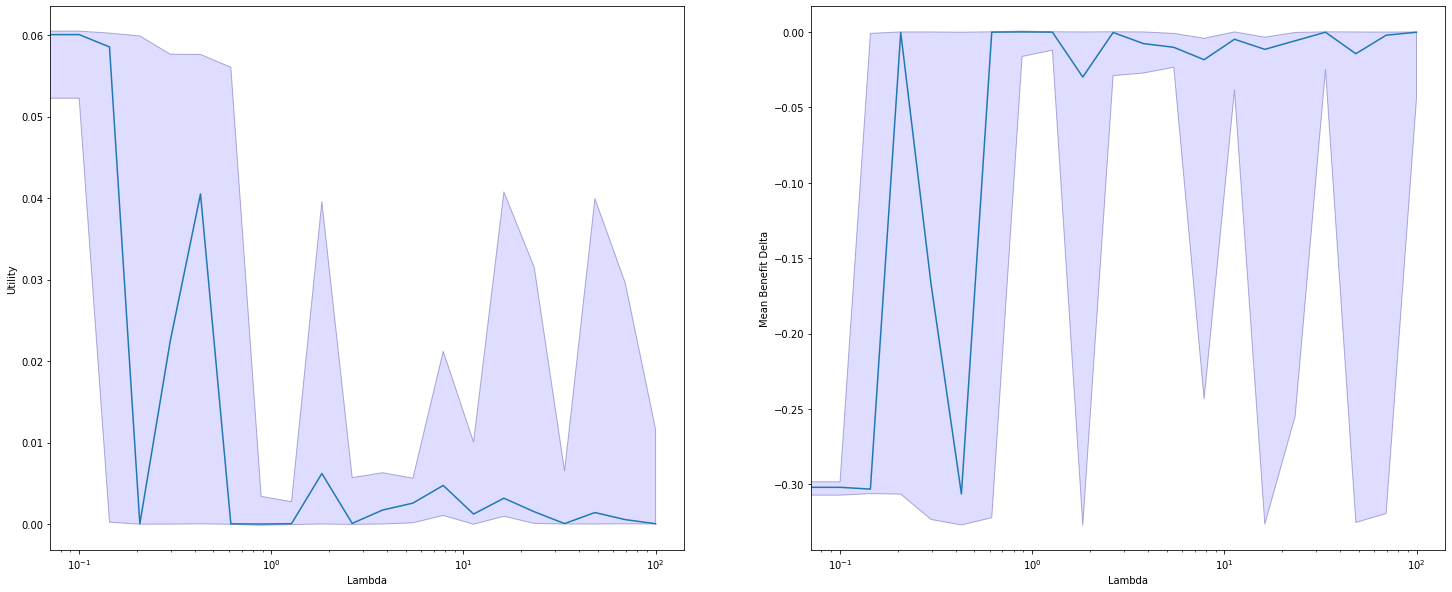

In [8]:
training_parameters["save_path"] = "/home/fkretschmar/Documents/master-thesis/res/exp-007/split/lambda"
lambdas = np.logspace(-1, 2, base=10, endpoint=True, num=20)
lambdas = np.insert(arr=lambdas, obj=0, values=[0.0])

statistics, run_path = train(training_parameters, fairness_rates=lambdas, iterations=30, verbose=True, asynchronous=True)

plot_mean_over_lambdas(statistics, "{}/results_mean_lambdas.png".format(run_path))
plot_median_over_lambdas(statistics, "{}/results_median_lambdas.png".format(run_path))